# Image Compression

install dependencies: `pip install tft pillow_jpls datasets livecodec`

## Load pre-trained codec

original image


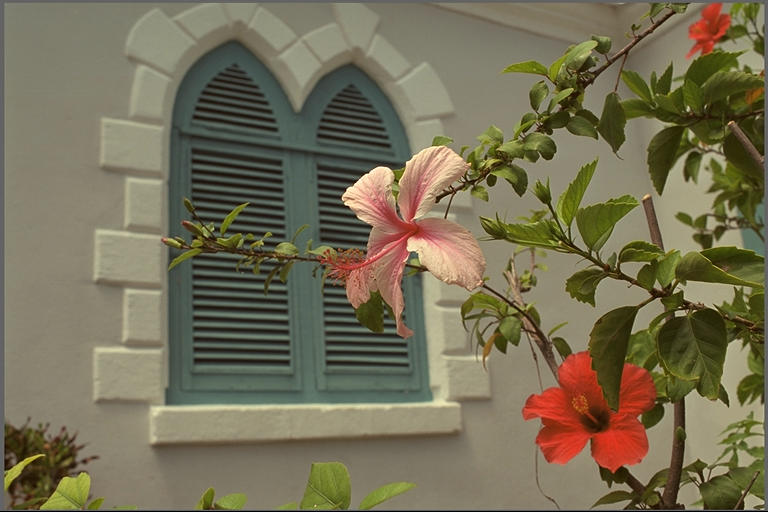

In [1]:
import pillow_jpls, torch, io, datasets, PIL.Image,  numpy as np, matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from types import SimpleNamespace
from livecodec.codec import AutoCodecND, latent_to_pil, pil_to_latent
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor, resize

# choose the device (comment the other one out)
device = 'cpu'; dtype=torch.float 
device = 'cuda'; dtype=torch.float


# Load some example images (kodak)
dataset = datasets.load_dataset("danjacobellis/kodak")
img = dataset['validation'][6]['image']

# Load the pre-trained codec
checkpoint_file = hf_hub_download(
    repo_id="danjacobellis/autocodec",
    filename="rgb_f16c12.pth"
)
checkpoint = torch.load(checkpoint_file, map_location="cpu",weights_only=False)
config = checkpoint['config']
codec = AutoCodecND(
    dim=2,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = 4,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
)
codec.load_state_dict(checkpoint['state_dict'])
codec.eval();
codec.to(dtype).to(device);
print('original image')
display(img)

## Apply the analysis transform

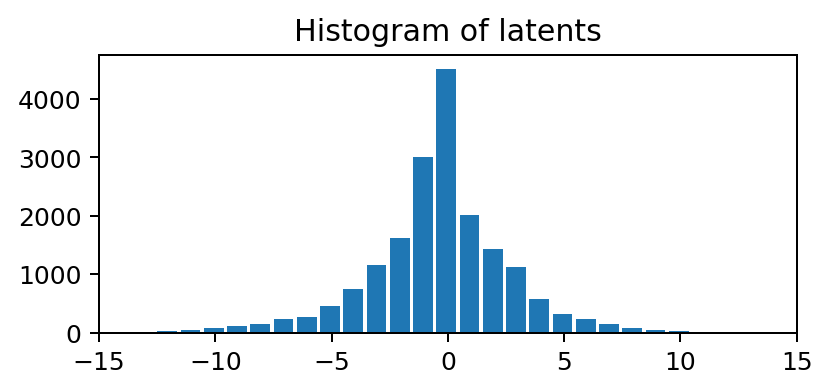

In [2]:
x = pil_to_tensor(img).to(device).unsqueeze(0).to(dtype).to(device) / 127.5 - 1.0
G_A = lambda x: codec.quantize.compand(codec.encode(x)).round()
with torch.no_grad():
    z = G_A(x)

plt.figure(figsize=(5,2),dpi=180)
plt.hist(z.float().cpu().flatten(), range=(-127.5,127.5),bins=255, width=0.85);
plt.xlim([-15,15])
plt.title('Histogram of latents');

## Entropy coding

compressed size: 7728 bytes
compressed latent as an RGB image:


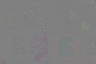

compressed latent as an RGB image (zoomed):


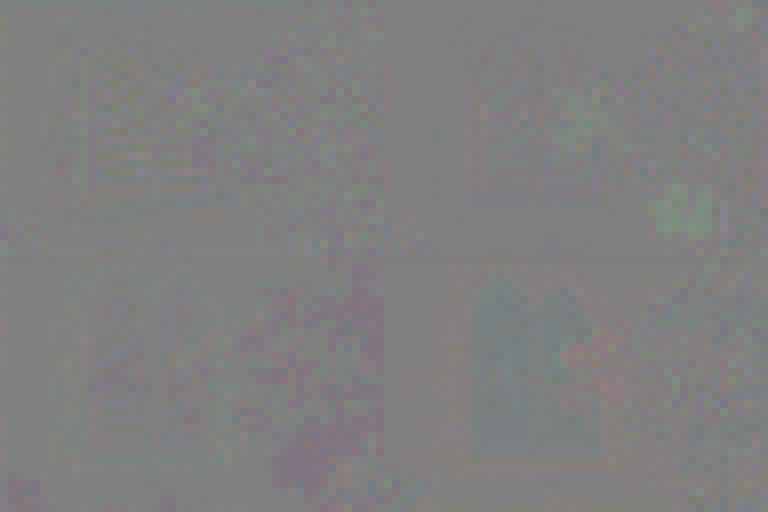

In [3]:
compressed = latent_to_pil(z.cpu(), n_bits=8, C=3)
buff = io.BytesIO()
compressed[0].save(buff, format='JPEG-LS')
size_bytes = len(buff.getbuffer())
print(f'compressed size: {size_bytes} bytes')
print(f'compressed latent as an RGB image:')
display(PIL.Image.open(buff))
print(f'compressed latent as an RGB image (zoomed):')
display(PIL.Image.open(buff).resize((768,512),resample=PIL.Image.Resampling.NEAREST))

## Decoding

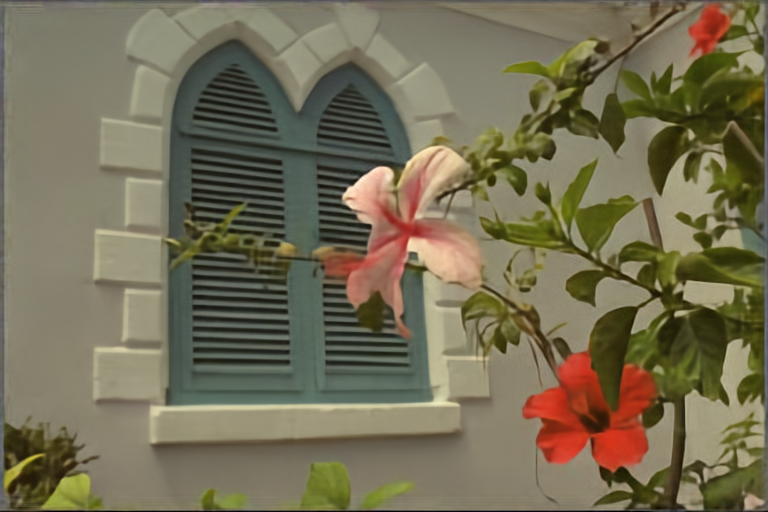

In [4]:
z = pil_to_latent(compressed, N=config.latent_dim, n_bits=8, C=3).to(device).to(dtype)
with torch.no_grad():
    x_hat = codec.decode(z).clamp(-1,1)
to_pil_image(x_hat[0]/2+0.5)